In [1]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://transferwise.okta-emea.com/app/snowflake/exk4istpb5gZUyV8u0i7/sso/saml?SAMLRequest=nZJPc9owEMW%2Fikc925KNA1QDZCiElAlQBkwOuSn2QlRsydXKGPrpK%2FOnkx6SQ28e%2Be3%2B3u7b3v2xyL0DGJRa9UkYMOKBSnUm1a5PNsnE7xIPrVCZyLWCPjkBkvtBD0WRl3xY2Te1gl8VoPVcI4W8%2BdEnlVFcC5TIlSgAuU35ejif8ShgXCCCsQ5HriUZSsd6s7bklNZ1HdStQJsdjRhjlH2lTtVIvpB3iPJzRmm01anObyVHN9MHiJCyuEE4hSMsr4XfpLqs4DPK60WE%2FHuSLP3lj3VCvOFtupFWWBVg1mAOMoXNanYxgM7BKok6cdQNoPJTUNaI3A8DVLre5mIPqS7KyrrGgfuiW8hornfSrWs67pNyL7P5btl5fCzmT8XvTmubLaIHs2j%2FXDxM8uNhuJ%2FDdLEvJiM9az1tUuI938KNmnCniBVMVROpdU8savss9COWsDa%2Fi3nMAsbiF%2BKNXaRSCXuuvPl2ThVuwdQSIdB7K3woQJxtirKkfyegcNzHEm35erd72ZyeuxWTHYqoaZMduZwPP1sxg%2F9YSo%2B%2Bb3A9xoXLZzpe6lymJ2%2BiTSHsx%2FGFQXh%2BkZm%2FPUs5FELmwywzgOhizHNdjwwI627emgoIHVyo%2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error

In [12]:
df = snowflake_client.fetch(f"""
SELECT *, 
       CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP) as NY_TIME,
       ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
WHERE CCY_PAIR IN ('USDCNY', 'USDCNH')
  AND TENOR_CODE = 'SP'
  AND INSTRUMENT_TYPE = 'FXSpot'
  AND PROVIDER = 'BLOOMBERG'
  AND TIMESTAMP BETWEEN '2024-01-01 00:00:00' AND '2026-01-14 23:59:59'  
  AND DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) <> 6
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 5 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) >= 17)
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 7 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) < 17);
""")
ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,USDCNH,USDCNY
timestamp,,
2024-01-01 00:00:00,NaN,7.10005
2024-01-01 01:00:00,NaN,7.10005
2024-01-01 02:00:00,NaN,7.10005
2024-01-01 03:00:00,NaN,7.10005
2024-01-01 04:00:00,NaN,7.10005


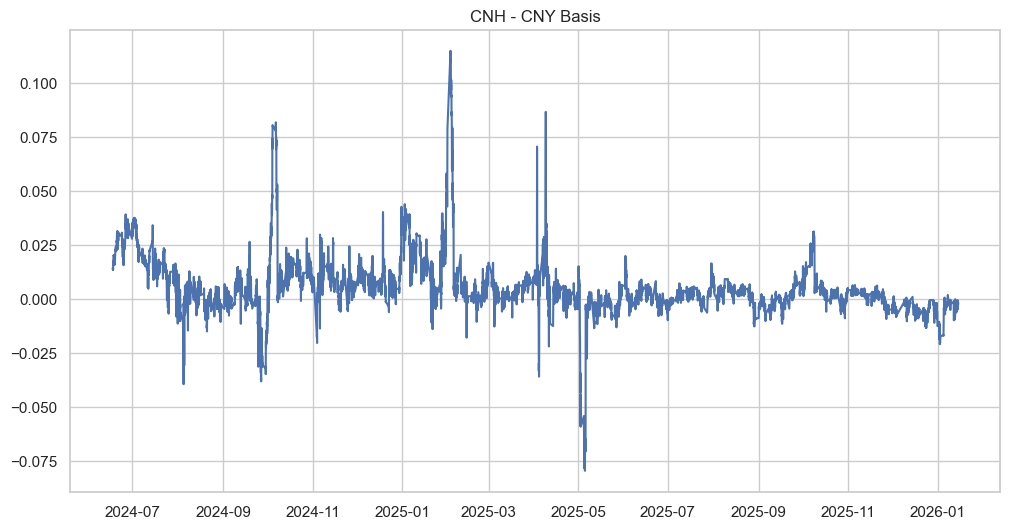

In [27]:
ccy_df = ccy_df.dropna()
ccy_df['basis'] = ccy_df['USDCNH'] - ccy_df['USDCNY']

sns.set_theme(style='whitegrid')
fig, ax =  plt.subplots(figsize=(12,6))
ax.plot(ccy_df.index, ccy_df['basis'])
plt.title("CNH - CNY Basis")
plt.show()

(array([  25.,   13.,   59., 1918., 6777.,  830.,  129.,   35.,   21.,
          15.]),
 array([-0.07965, -0.06018, -0.04071, -0.02124, -0.00177,  0.0177 ,
         0.03717,  0.05664,  0.07611,  0.09558,  0.11505]),
 <BarContainer object of 10 artists>)

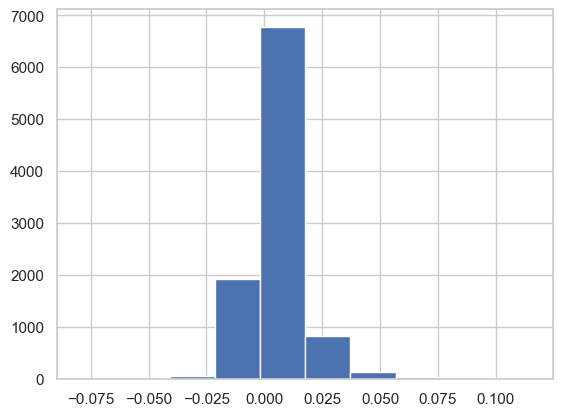

In [25]:
plt.hist(ccy_df['basis'])

<Axes: xlabel='timestamp'>

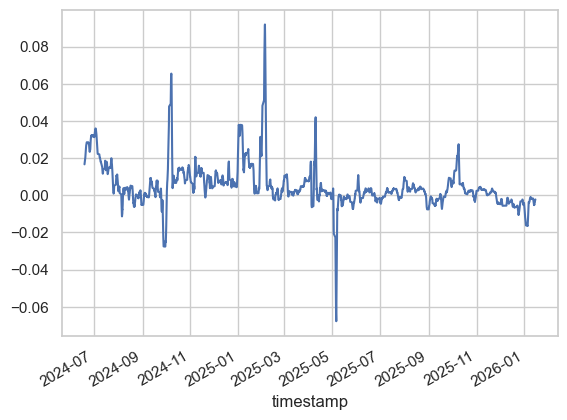

In [30]:
ccy_df['basis'].rolling(30).mean().plot()

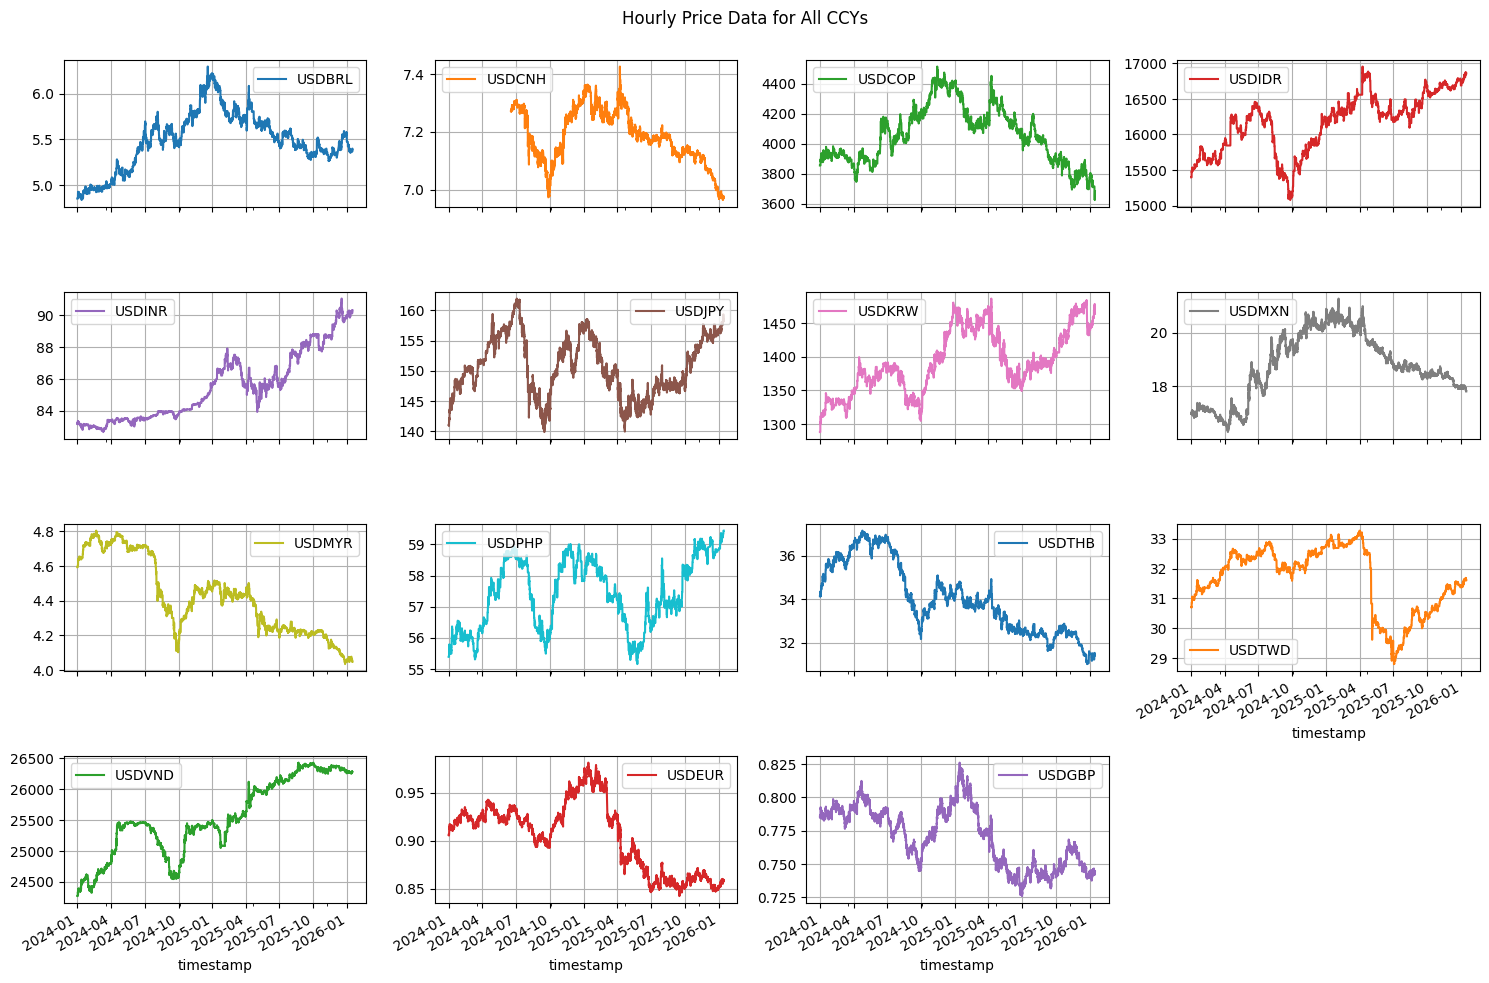

In [5]:
# rebasing

ccy_df['USDEUR'] = 1/ccy_df['EURUSD']
ccy_df['USDGBP'] = 1/ccy_df['GBPUSD']

rebased_ccy = ccy_df.drop(columns=['GBPUSD', 'EURUSD'])

rebased_ccy.plot(
    subplots=True,
    layout=(5,4),
    figsize=(15,12),
    title='Hourly Price Data for All CCYs',
    grid=True,
    sharex=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

<Axes: xlabel='timestamp'>

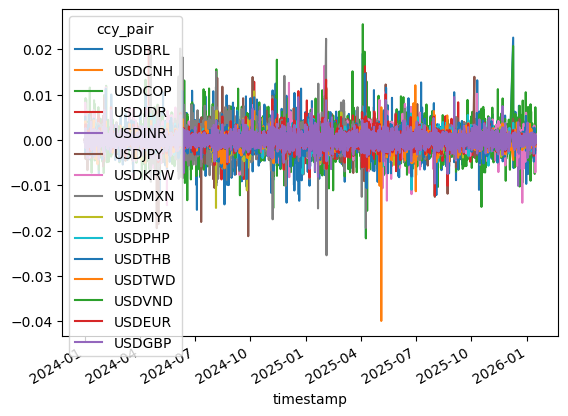

In [46]:
# log returns

log_returns = np.log(rebased_ccy/rebased_ccy.shift(1))
log_returns.plot()

<Axes: xlabel='timestamp'>

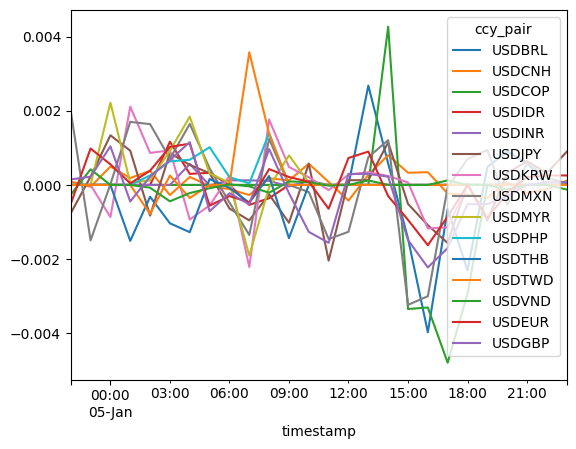

In [32]:
log_returns.loc["2026-01-04":"2026-01-05"].plot()

In [48]:
# split into train/test

split = 0.8*len(log_returns)
train_data = log_returns.iloc[:int(split)]
test_data = log_returns.iloc[int(split):]

train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10176 entries, 2024-01-01 00:00:00 to 2025-08-14 22:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDBRL  10175 non-null  float64
 1   USDCNH  7276 non-null   float64
 2   USDCOP  10175 non-null  float64
 3   USDIDR  10175 non-null  float64
 4   USDINR  10175 non-null  float64
 5   USDJPY  10175 non-null  float64
 6   USDKRW  10175 non-null  float64
 7   USDMXN  10175 non-null  float64
 8   USDMYR  10175 non-null  float64
 9   USDPHP  10175 non-null  float64
 10  USDTHB  10175 non-null  float64
 11  USDTWD  10175 non-null  float64
 12  USDVND  10175 non-null  float64
 13  USDEUR  10175 non-null  float64
 14  USDGBP  10175 non-null  float64
dtypes: float64(15)
memory usage: 1.2 MB


In [92]:
from statsmodels.tsa.stattools import adfuller

X = train_data[train_data.columns]

adf_data = pd.DataFrame()
adf_data['CCY'] = X.columns
adf_data['adf_statistic'] = [adfuller(train_data[col].dropna())[0] for col in X.columns]
adf_data['p-value'] = [adfuller(train_data[col].dropna())[1] for col in X.columns]
adf_data['used_lag'] = [adfuller(train_data[col].dropna())[2] for col in X.columns]
adf_data['num_obs'] = [adfuller(train_data[col].dropna())[3] for col in X.columns]

In [93]:
adf_data

,CCY,adf_statistic,p-value,used_lag,num_obs
0,USDBRL,-40.549301,0.000000e+00,5,10169
1,USDCNH,-59.610988,0.000000e+00,1,7274
2,USDCOP,-18.319805,2.267066e-30,26,10148
3,USDIDR,-17.748327,3.378596e-30,28,10146
4,USDINR,-20.969788,0.000000e+00,26,10148
5,USDJPY,-21.018746,0.000000e+00,24,10150
6,USDKRW,-73.021069,0.000000e+00,1,10173
7,USDMXN,-20.960276,0.000000e+00,24,10150
8,USDMYR,-18.457288,2.149354e-30,25,10149
9,USDPHP,-20.291871,0.000000e+00,24,10150


## log prices to test for cointegration

In [99]:
log_prices = np.log(rebased_ccy)

# train data

split_point = 0.8*len(log_prices)
train_data = log_prices.iloc[:int(split_point)]
test_data = log_prices.iloc[int(split):]

train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10176 entries, 2024-01-01 00:00:00 to 2025-08-14 22:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDBRL  10176 non-null  float64
 1   USDCNH  7277 non-null   float64
 2   USDCOP  10176 non-null  float64
 3   USDIDR  10176 non-null  float64
 4   USDINR  10176 non-null  float64
 5   USDJPY  10176 non-null  float64
 6   USDKRW  10176 non-null  float64
 7   USDMXN  10176 non-null  float64
 8   USDMYR  10176 non-null  float64
 9   USDPHP  10176 non-null  float64
 10  USDTHB  10176 non-null  float64
 11  USDTWD  10176 non-null  float64
 12  USDVND  10176 non-null  float64
 13  USDEUR  10176 non-null  float64
 14  USDGBP  10176 non-null  float64
dtypes: float64(15)
memory usage: 1.2 MB


In [100]:
X = train_data[train_data.columns]

adf_data = pd.DataFrame()
adf_data['CCY'] = X.columns
adf_data['adf_statistic'] = [adfuller(train_data[col].dropna())[0] for col in X.columns]
adf_data['p-value'] = [adfuller(train_data[col].dropna())[1] for col in X.columns]
adf_data['used_lag'] = [adfuller(train_data[col].dropna())[2] for col in X.columns]
adf_data['num_obs'] = [adfuller(train_data[col].dropna())[3] for col in X.columns]

In [101]:
adf_data

,CCY,adf_statistic,p-value,used_lag,num_obs
0,USDBRL,-2.021261,0.277329,6,10169
1,USDCNH,-2.107145,0.241651,0,7276
2,USDCOP,-2.211848,0.201973,27,10148
3,USDIDR,-2.010284,0.282082,29,10146
4,USDINR,-0.396033,0.910759,27,10148
5,USDJPY,-2.411689,0.138464,0,10175
6,USDKRW,-2.460574,0.125364,2,10173
7,USDMXN,-1.539126,0.514075,25,10150
8,USDMYR,-0.651958,0.858804,26,10149
9,USDPHP,-2.244693,0.190426,25,10150


In [ ]:
# testing for cointegration

from statsmodels.tsa.stattools import coint

log_price_gbp = train_data['USDGBP']
log_price_eur = train_data['USDEUR']